# Wavelets decomposition

- author Sylvie Dagoret-Campagne
- creation date August 14th 2020

In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import os,sys

from astropy.io import fits
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
from matplotlib import gridspec
%matplotlib inline

In [108]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [109]:
sys.path.append("../../tools/atmanalyticsim") # go to parent dir

In [110]:
import libatmscattering as atm

In [111]:
import pywt

In [112]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)
plt.rcParams['font.size'] = 18

In [113]:
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=18, usetex=True)

In [114]:
DATADIR="../../data/atm"

In [115]:
atmospheric_basename_files=os.listdir(DATADIR)

In [116]:
atmospheric_basename_files

['lsst_atm_10year_bintab.parquet',
 'lsst_atm_10year_01.fits',
 'lsst_atm_10year_bigimg.fits',
 'lsst_atm_10year_07.fits',
 'lsst_atm_10year_06.fits',
 'lsst_atm_10year_10.fits',
 'lsst_atm_10year_09.fits',
 'lsst_atm_10year_bintab.fits',
 'lsst_atm_10year_05.fits',
 'lsst_atm_10year_04.fits',
 'lsst_atm_10year_bintab_small.fits',
 'lsst_atm_10year_08.fits',
 'lsst_atm_10year_03.fits',
 '.ipynb_checkpoints',
 'lsst_atm_10year_02.fits']

In [117]:
input_file=os.path.join(DATADIR,'lsst_atm_10year_bigimg.fits')

In [118]:
hdu = fits.open(input_file)

In [119]:
hdr=hdu[0].header
data=hdu[0].data

In [120]:
hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  958                                                  
NAXIS2  =                 3651                                                  
NBATMSIM=                 3650                                                  
ID_NUM  =                    0                                                  
ID_YEAR =                    1                                                  
ID_AM   =                    2                                                  
ID_VAOD =                    3                                                  
ID_PWV  =                    4                                                  
ID_O3   =                    5                                                  
ID_CLD  =                   

In [121]:
NbAtmSimul=hdr['NBATMSIM']
idx_out_num=hdr['ID_NUM']
idx_out_year=hdr['ID_YEAR']
idx_out_am=hdr['ID_AM']
idx_out_vaod=hdr['ID_VAOD']
idx_out_pwv=hdr['ID_PWV']
idx_out_o3=hdr['ID_O3']
idx_out_cld=hdr['ID_CLD']
idx_out_res=hdr['ID_RES']

In [122]:
num=data[1:,idx_out_num]
year=data[1:,idx_out_year]
airmass=data[1:,idx_out_year]
vaod=data[1:,idx_out_vaod] # vertical aerosol depth
pwv=data[1:,idx_out_pwv]   # precipitable water vapor (mm)
o3=data[1:,idx_out_o3]     # ozone
cld=data[1:,idx_out_cld]   # clouds (not used)

In [123]:
# Extract wavelength Wavelength
wl=data[0,idx_out_res:]
transm=data[1:,idx_out_res:]

In [124]:
NWL=wl.shape[0]

In [125]:
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NWL)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NWL), alpha=1)

# Prepare data

In [126]:
vaodarr=vaod[:,np.newaxis]
pwvarr=pwv[:,np.newaxis]
o3arr=o3[:,np.newaxis]

In [127]:
Y=np.concatenate((vaodarr,pwvarr,o3arr),axis=1)

In [128]:
indexes_selected=np.where(np.logical_and(wl>350,wl<=1100))[0]

In [129]:
# need even number of bins
if len(indexes_selected)%2:
    indexes_selected=indexes_selected[:-1]

In [130]:
len(indexes_selected)

750

In [131]:
wl=wl[indexes_selected]
transm=transm[:,indexes_selected]

In [132]:
#transm0=transm[0]*0.96
transm0=transm[0]

In [133]:
od=atm.RayOptDepth_adiabatic(wl, altitude=atm.altitude0, costh=1/1.2)
att_rayleigh=np.exp(-od)

Text(0, 0.5, 'att (mag)')

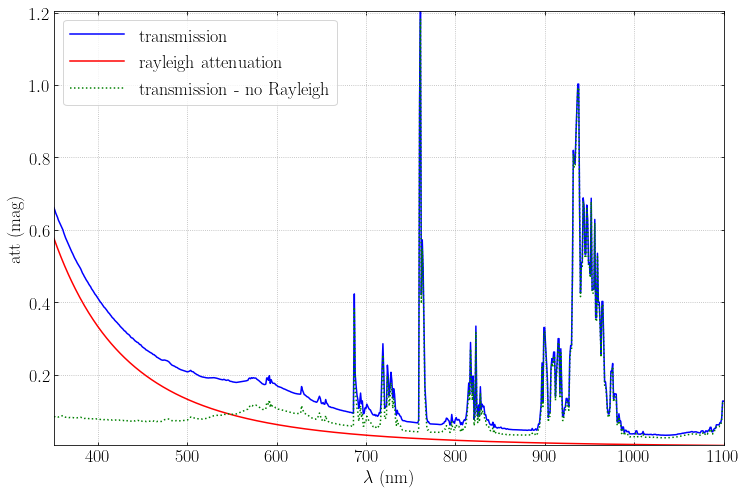

In [134]:
ax = plt.subplot(111)
ax.plot(wl,-2.5*np.log10(transm0),'b-',label="transmission")
ax.plot(wl,-2.5*np.log10(att_rayleigh),'r-',label="rayleigh attenuation")
ax.plot(wl,-2.5*np.log10(transm0/att_rayleigh),'g:',label="transmission - no Rayleigh")
ax.legend()
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("att (mag)")

# wavelet decomposition

In [135]:
# correction from Rayleigh
t=wl
h=-2.5*np.log10(transm0/att_rayleigh)

In [136]:
w = pywt.Wavelet("db1")
coeffs = pywt.wavedec(h, w, level=6)

In [137]:
coeffs

[array([0.64836497, 0.59102005, 0.64299237, 0.84255462, 0.68380666,
        0.75330383, 0.8462184 , 0.58198864, 0.84574331, 2.93433672,
        0.23514141, 0.43231399]),
 array([ 0.0204875 ,  0.00519765, -0.03024378, -0.04930187,  0.08309889,
        -0.06639521,  0.45482279,  0.20086125, -0.5580599 ,  1.55184823,
         0.00940005, -0.1337991 ]),
 array([ 0.0072754 ,  0.00594302,  0.00411304, -0.00372699, -0.01129113,
        -0.02424541, -0.03901685,  0.00149263,  0.01060604,  0.03158448,
        -0.14318898, -0.17216471, -0.62555975, -0.00788713, -0.21268311,
         0.05890667, -0.00871359,  0.05972477,  0.20256177,  0.44461527,
         0.00880951, -0.0054185 , -0.00976623,  0.        ]),
 array([-9.74810577e-04, -5.84005005e-04,  2.19692594e-03,  2.00400221e-03,
         2.15453666e-03,  4.73871498e-04,  5.62061045e-04, -6.44687841e-03,
         3.60399657e-03, -1.19763312e-02, -5.05792425e-03, -4.66974987e-03,
        -2.40257204e-03, -2.35096138e-02,  7.59483686e-03,  2.0939

In [138]:
full_rec=pywt.waverec(coeffs, w)


coeffs[6] = np.zeros_like(coeffs[6])
coeffs[5] = np.zeros_like(coeffs[5])

rec_1=pywt.waverec(coeffs, w)

coeffs[4] = np.zeros_like(coeffs[4])
coeffs[3] = np.zeros_like(coeffs[3])

rec_2=pywt.waverec(coeffs, w)

coeffs[2] = np.zeros_like(coeffs[2])
coeffs[1] = np.zeros_like(coeffs[1])

rec_3=pywt.waverec(coeffs, w)


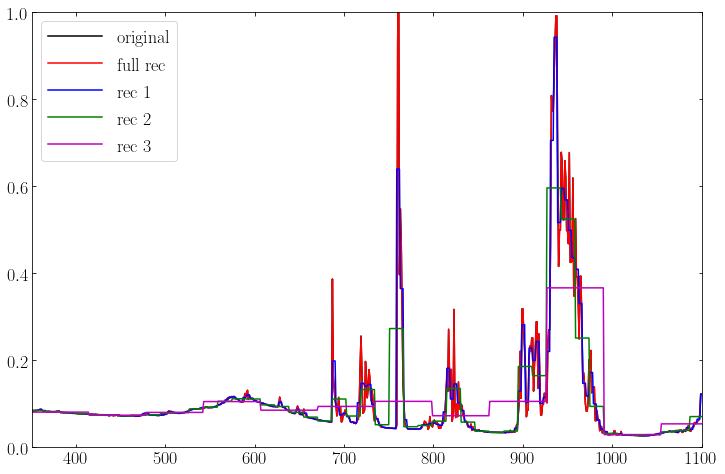

In [139]:
ax = plt.subplot(111)

ax.plot(t,h,"k-",label="original")
ax.plot(t,full_rec,"r-",label="full rec")
ax.plot(t,rec_1,"b-",label="rec 1")
ax.plot(t,rec_2,"g-",label="rec 2")
ax.plot(t,rec_3,"m-",label="rec 3")
ax.set_ylim(0,1)
ax.legend()